## Food Vision Big Project

In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds
from helper_function import create_tensorboard_callback, plot_loss_curve, compare_history
import os
import matplotlib.pyplot as plt

### 1. Data preparation

In [8]:
### Get all available datasets in TFDS

datasets_list = tfds.list_builders()

In [9]:
### Check if the dataset exist

target_dataset = "food101"

print(f"'{target_dataset}' in TensorFlow Datasets: {target_dataset in datasets_list}")

'food101' in TensorFlow Datasets: True


In [10]:
(train_data, test_data), ds_info = tfds.load(
    name = "food101", # Dataset name
    split = ["train", "validation"], # What kind of split data should we have? Not all dataset have train, valid and test.
    shuffle_files = True, # Shuffle file while downloading
    as_supervised = True, # Download data in tuple format (sample, label), example: (image, label)
    with_info = True) # Include dataset metadata

In [11]:
# Features of Food101 TFDS

ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [12]:
# All class name of Food101

class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [13]:
# Take one sample from training data and explore it

train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [19]:
# Output info of one training sample

for image, label in train_one_sample:
    print(f"""Image shape: {image.shape}, Image dtype: {image.dtype}, Target class from Food101 (tensor form): {label}
       Class name (str form): {class_names[label.numpy()]}""")

Image shape: (512, 384, 3), Image dtype: <dtype: 'uint8'>, Target class from Food101 (tensor form): 74
       Class name (str form): peking_duck


In [20]:
### Image in tensor form

image

<tf.Tensor: shape=(512, 384, 3), dtype=uint8, numpy=
array([[[152, 129,  77],
        [160, 137,  85],
        [160, 137,  85],
        ...,
        [ 26,  21,  18],
        [ 24,  19,  16],
        [ 21,  16,  13]],

       [[156, 133,  81],
        [158, 135,  83],
        [155, 132,  80],
        ...,
        [ 25,  20,  17],
        [ 23,  18,  15],
        [ 22,  17,  14]],

       [[164, 141,  87],
        [159, 136,  82],
        [147, 124,  70],
        ...,
        [ 23,  18,  15],
        [ 21,  17,  14],
        [ 20,  16,  13]],

       ...,

       [[  1,  49, 121],
        [  0,  47, 119],
        [  0,  48, 120],
        ...,
        [ 26,  14,  16],
        [ 26,  14,  16],
        [ 32,  20,  22]],

       [[  1,  49, 121],
        [  0,  47, 119],
        [  0,  48, 120],
        ...,
        [ 24,  14,  15],
        [ 30,  18,  18],
        [ 30,  18,  18]],

       [[  2,  50, 122],
        [  0,  48, 120],
        [  0,  48, 120],
        ...,
        [ 22,  12,  1

In [22]:
# Min and max value of image

print(f"min: {tf.reduce_min(image)}, max: {tf.reduce_max(image)}")

min: 0, max: 255


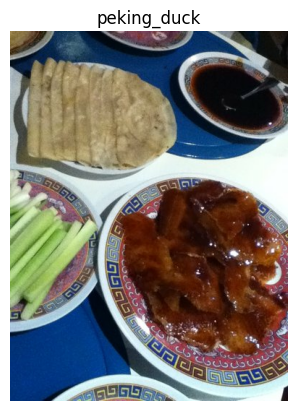

In [23]:
# Visualization of image tensor

plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);